## Task 2: Image Reconstruction (50)
Create an "all-in-focus image" using the best result from all scales.

The structure of the algorithm is the following:
- Deblur the entire image for each of scaled kernels.
- Compute reconstruction error $e_k$ for each of the scaled images.
- For small windows around every pixel, compute the error of that pixel,
- Select the minimum and create a depth map with the selected depths.

Preparing data:

In [1]:
from IPython.display import Image
import numpy as np
import cv2
import scipy.io
from lib.display_helper import *
from lib.log import log_message
from lib.deconvolution import *

matlab_files = [scipy.io.loadmat("CodedApertureData/filts/filt_scl0"+str(i)+".mat") for i in range(1,10)]
kernels = [flip_kernel(ml_file['filts'][0,3]) for ml_file in matlab_files]
image = cv2.imread('CodedApertureData/cups_board_inp.bmp');

outputs = deconvolution_L2(image, kernels)
fh, fw = outputs[0].shape[0]-image.shape[0], outputs[0].shape[1]-image.shape[1]
hfh, hfw = fh/2, fw/2

Computing errors and masks:

In [99]:
from scipy.ndimage import convolve

def compute_reconstruction_errors(image, kernels, deconvs, filter_size=9):
    (h, w,c) = image.shape
    convs = np.zeros((len(kernels),h,w,c), np.float32)
    for k in range(len(kernels)):
        for i in range(c):
            convs[k,...,i] = convolve(deconvs[k,...,i], kernels[k])
    errors = image - convs
    e_sq = errors**2
    box_kernel = np.ones((filter_size, filter_size), np.float32)
    approx_errors = np.zeros((len(kernels),h,w,c), np.float32)
    for k in range(len(kernels)):
        for i in range(c):
            approx_errors[k,...,i] = convolve(e_sq[k,...,i], box_kernel)
    return errors, approx_errors

def compute_reconstruction_masks(approx_errors):
    nkernels = len(approx_errors)
    errors_sum = np.sum(approx_errors,axis=-1)
    errors_sum = np.repeat(errors_sum[...,None], 3, axis=-1)
    contribution_map  = np.argmin(errors_sum, axis=0)
    (h,w,c) = contribution_map.shape
    masks = np.zeros((nkernels,h,w,c), np.float32)
    for k in range(nkernels):
        masks[k,...] = np.where(contribution_map==k, 1, 0)
    return contribution_map, masks

def compute_image_reconstruction(deconvs, masks):
    masked_deconvs = deconvs*masks
    output = np.sum(masked_deconvs, axis=0)
    return output

Output:

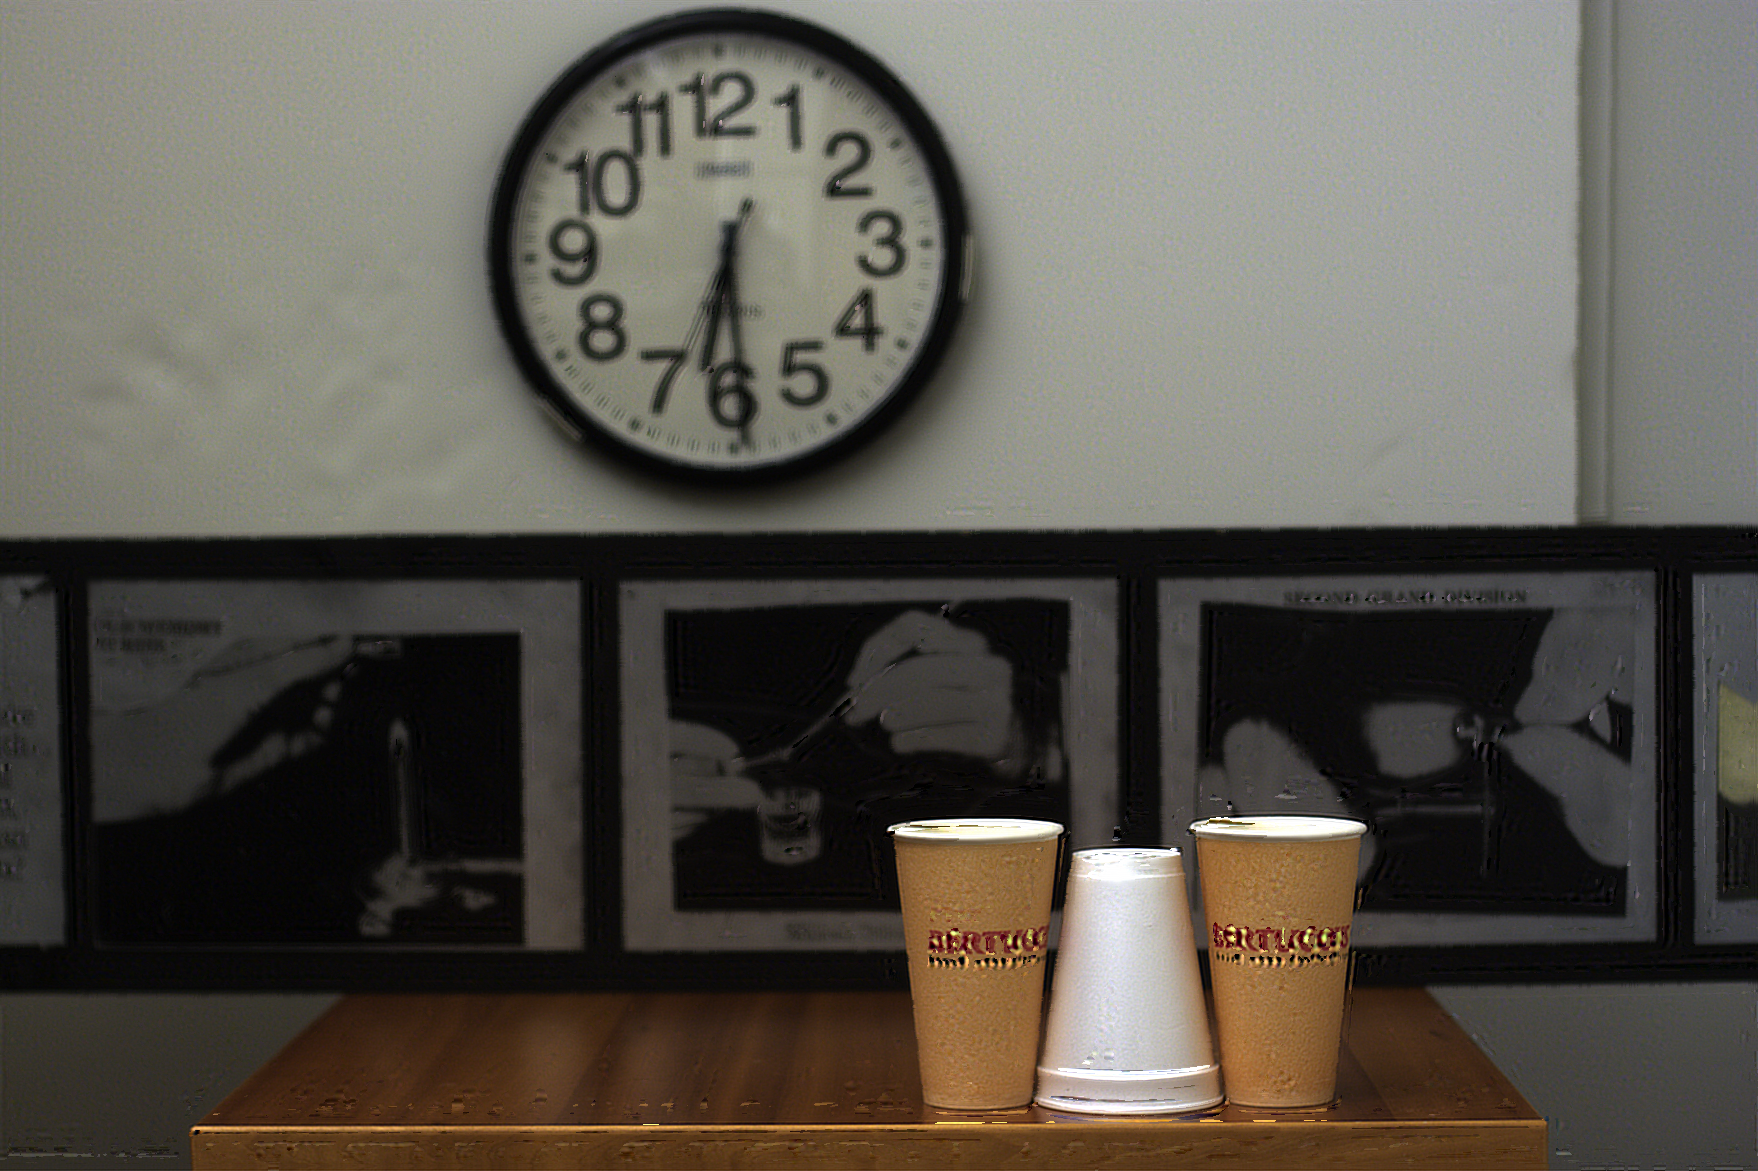

In [108]:
deconvs = outputs.copy()
deconvs = deconvs[:,hfh:-hfh, hfw:-hfw,:]
log_message("Computing reconstruction errors...")
errors, approx_errors = compute_reconstruction_errors(image, kernels, deconvs, 11)
log_message("Computing reconstruction masks...")
contribution_map, masks = compute_reconstruction_masks(approx_errors)
log_message("Computing reconstructed image...")
output = compute_image_reconstruction(deconvs, masks)
output_path = 'output/task2.png'
cv2.imwrite(output_path, output)
Image(output_path)

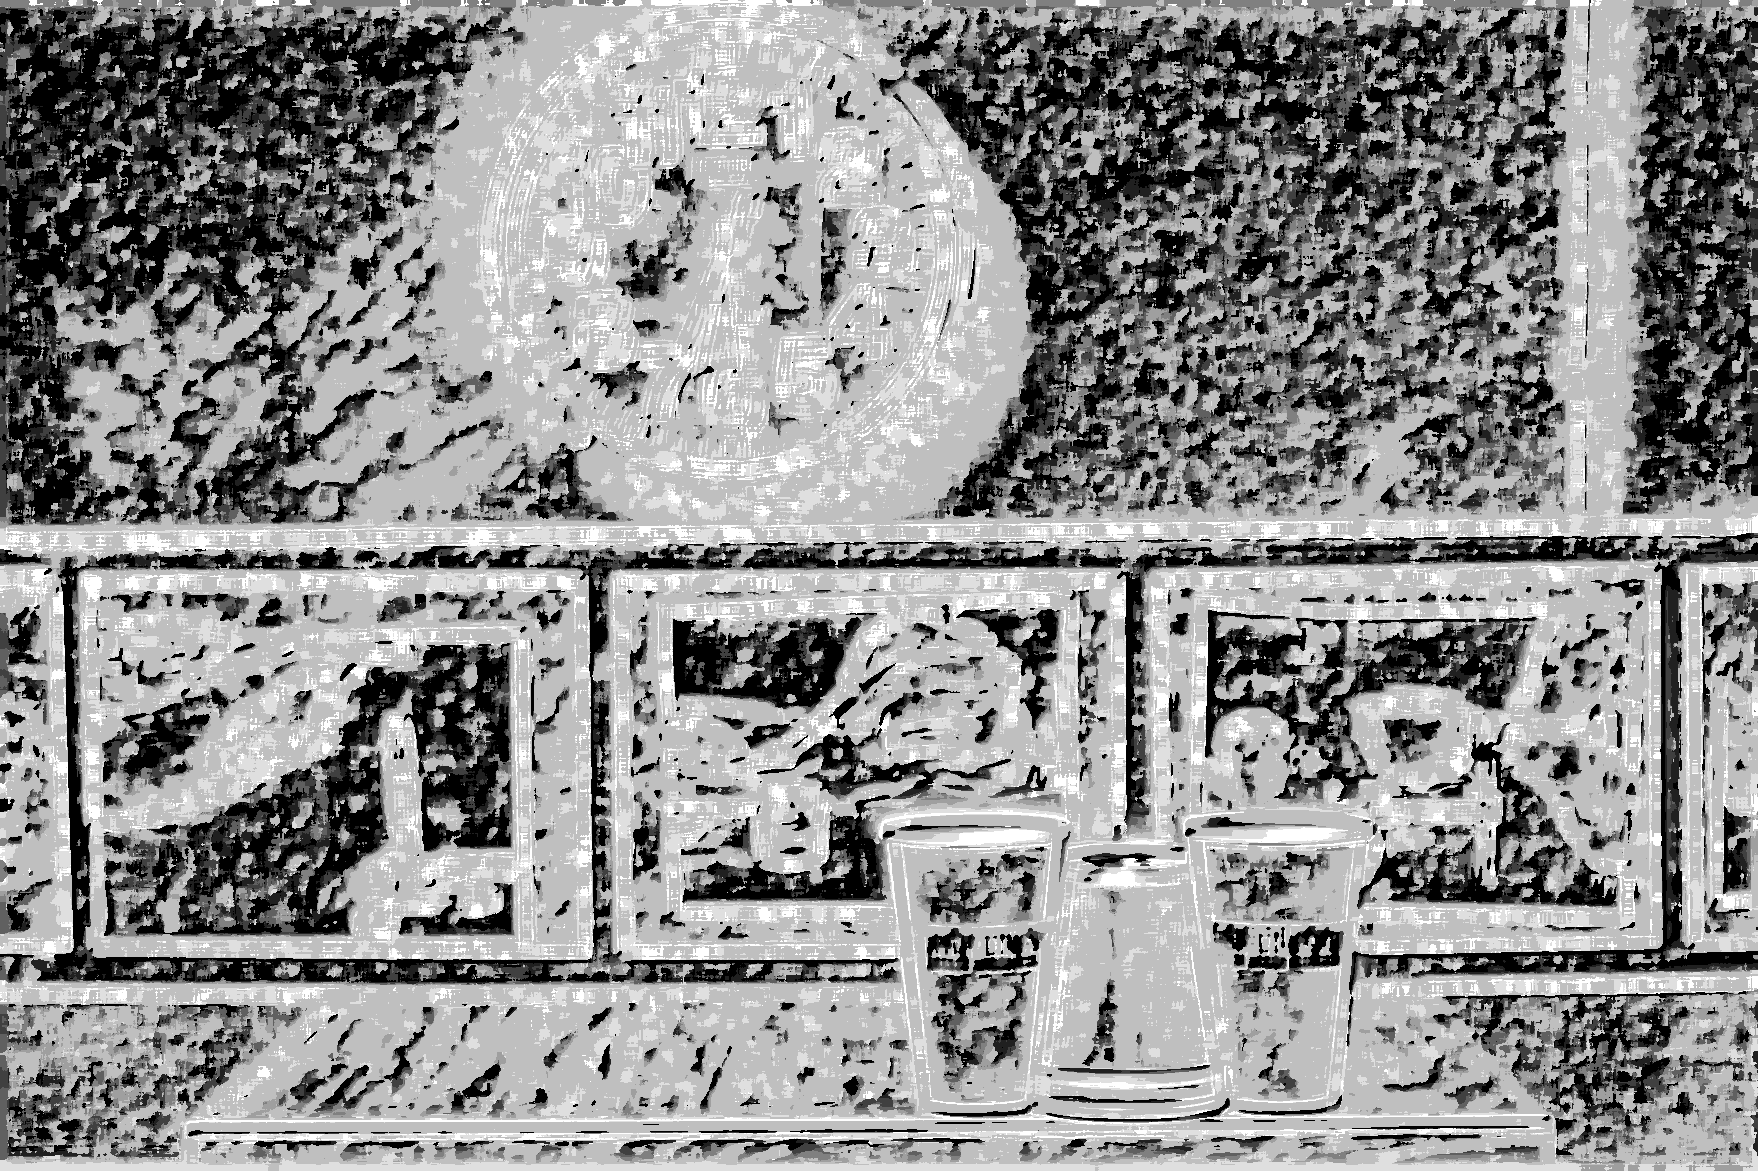

In [109]:
dbg_path = 'output/dbg.png'
cv2.imwrite(dbg_path, contribution_map*255./np.max(contribution_map))
Image(dbg_path)